# Word Detection

In [11]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import cv2
import numpy as np
import math
from sklearn.cluster import DBSCAN


@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.

    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.

    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.

    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.

    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.

    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]

Processing file ./images/a01-000u.png
44 62 32 37
179 71 19 14
121 57 164 37
334 59 63 37
427 54 133 53
627 52 89 42
815 45 293 55
1156 52 139 52
34 185 341 73
414 201 118 61
571 201 163 33
786 186 227 45
1070 182 136 48
1243 181 183 56
45 339 58 26
143 325 64 38
279 318 91 48
425 334 218 37
698 322 67 41
791 337 55 26
894 322 261 70
1187 313 76 53
1303 324 234 48
61 453 48 32
108 445 55 41
164 467 39 29
266 457 331 39
570 474 15 12
694 454 115 43
913 457 17 10
861 457 250 39
1173 449 148 50
1370 460 108 40
32 589 128 51
200 594 176 36
406 606 52 24
498 593 328 40
876 606 67 26
983 592 133 44
1167 587 244 71
23 727 153 37
221 724 103 37
355 742 49 24
426 730 72 37
531 726 110 43
682 726 240 38
986 730 85 50
1121 718 99 41
1298 722 56 38
1357 749 22 15
1368 726 50 37
12 851 159 51
176 858 106 40
307 891 19 20
396 859 57 40
454 846 71 47
589 852 129 53
778 860 336 41
1168 858 348 49


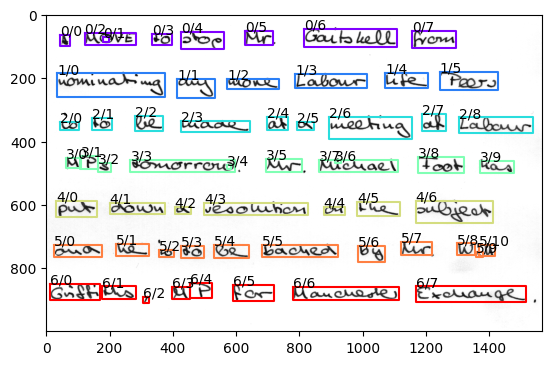

In [18]:
import os
from path import Path
import cv2
import matplotlib.pyplot as plt
from typing import List
import warnings
warnings.filterwarnings("ignore")

# Define parameters directly
data_dir = Path('./images')
kernel_size = 25
sigma = 11.0
theta = 7.0
min_area = 100
img_height = 1000
list_img_names_serial = []

def get_img_files(data_dir: Path) -> List[Path]:
    """Return all image files contained in a folder."""
    res = []
    for ext in ['*.png', '*.jpg', '*.bmp']:
        res += Path(data_dir).files(ext)
    return res

def save_image_names_to_text_files():
    for fn_img in get_img_files(data_dir):
        print(f'Processing file {fn_img}')

        # Assume prepare_img, detect, sort_multiline functions are defined elsewhere
        img = prepare_img(cv2.imread(fn_img), img_height)
        detections = detect(img, kernel_size=kernel_size, sigma=sigma, theta=theta, min_area=min_area)
        lines = sort_multiline(detections)

        plt.imshow(img, cmap='gray')
        num_colors = 7
        colors = plt.cm.get_cmap('rainbow', num_colors)
        for line_idx, line in enumerate(lines):
            for word_idx, det in enumerate(line):
                xs = [det.bbox.x, det.bbox.x, det.bbox.x + det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
                ys = [det.bbox.y, det.bbox.y + det.bbox.h, det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
                plt.plot(xs, ys, c=colors(line_idx % num_colors))
                plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
                print(det.bbox.x, det.bbox.y, det.bbox.w, det.bbox.h)
                crop_img = img[det.bbox.y:det.bbox.y + det.bbox.h, det.bbox.x:det.bbox.x+det.bbox.w]

                path = './test_images'
                if not os.path.exists(path):
                    os.mkdir(path)
                    print("Directory Created")

                cv2.imwrite(f"./test_images/line{line_idx}word{word_idx}.jpg", crop_img)
                full_img_path = f"line{line_idx}word{word_idx}.jpg"
                list_img_names_serial.append(full_img_path)

        textfile = open("img_names_sequence.txt", "w")
        for element in list_img_names_serial:
            textfile.write(element + "\n")
        textfile.close()
        plt.show()

save_image_names_to_text_files()

# Word Recognition

In [20]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [22]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0] =="#":
    continue
  if line.split(" ")[1] != "err":
    words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [23]:
print(words_list[0:10])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']


In [24]:
split_idx = int(0.9*len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total Training Samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total Training Samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [25]:
base_image_path = os.path.join(base_path, "words")
print(base_path)
def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    # Each line split willl have this format for the the corresponding image:
    # part1/part1-part2/part1-part2-part3.png
    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI, partI + "-" + partII, image_name + ".png"
    )
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

data


In [32]:
base_image_path = os.path.join(base_path, "test_imgs")
print(base_image_path)

t_images = []
from os import listdir
from os.path import isfile, join

# onlyfiles = [f for f in listdir(base_image_path) if isfile(join(base_image_path, f))]
for f in listdir(base_image_path):
  t_images_path = os.path.join(base_image_path, f)
  t_images.append(t_images_path)

print(t_images)

data/test_imgs
['data/test_imgs/line0word0.jpg', 'data/test_imgs/line0word1.jpg', 'data/test_imgs/line0word2.jpg', 'data/test_imgs/line0word3.jpg', 'data/test_imgs/line0word4.jpg', 'data/test_imgs/line0word5.jpg', 'data/test_imgs/line0word6.jpg', 'data/test_imgs/line0word7.jpg', 'data/test_imgs/line1word0.jpg', 'data/test_imgs/line1word1.jpg', 'data/test_imgs/line1word2.jpg', 'data/test_imgs/line1word3.jpg', 'data/test_imgs/line1word4.jpg', 'data/test_imgs/line1word5.jpg', 'data/test_imgs/line2word0.jpg', 'data/test_imgs/line2word1.jpg', 'data/test_imgs/line2word2.jpg', 'data/test_imgs/line2word3.jpg', 'data/test_imgs/line2word4.jpg', 'data/test_imgs/line2word5.jpg', 'data/test_imgs/line2word6.jpg', 'data/test_imgs/line2word7.jpg', 'data/test_imgs/line2word8.jpg', 'data/test_imgs/line3word0.jpg', 'data/test_imgs/line3word1.jpg', 'data/test_imgs/line3word2.jpg', 'data/test_imgs/line3word3.jpg', 'data/test_imgs/line3word4.jpg', 'data/test_imgs/line3word5.jpg', 'data/test_imgs/line3word6.

In [33]:
t_images[0:10]

['data/test_imgs/line0word0.jpg',
 'data/test_imgs/line0word1.jpg',
 'data/test_imgs/line0word2.jpg',
 'data/test_imgs/line0word3.jpg',
 'data/test_imgs/line0word4.jpg',
 'data/test_imgs/line0word5.jpg',
 'data/test_imgs/line0word6.jpg',
 'data/test_imgs/line0word7.jpg',
 'data/test_imgs/line1word0.jpg',
 'data/test_imgs/line1word1.jpg']

In [34]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

t_images.sort(key=natural_keys)
print(t_images)

['data/test_imgs/line0word0.jpg', 'data/test_imgs/line0word1.jpg', 'data/test_imgs/line0word2.jpg', 'data/test_imgs/line0word3.jpg', 'data/test_imgs/line0word4.jpg', 'data/test_imgs/line0word5.jpg', 'data/test_imgs/line0word6.jpg', 'data/test_imgs/line0word7.jpg', 'data/test_imgs/line1word0.jpg', 'data/test_imgs/line1word1.jpg', 'data/test_imgs/line1word2.jpg', 'data/test_imgs/line1word3.jpg', 'data/test_imgs/line1word4.jpg', 'data/test_imgs/line1word5.jpg', 'data/test_imgs/line2word0.jpg', 'data/test_imgs/line2word1.jpg', 'data/test_imgs/line2word2.jpg', 'data/test_imgs/line2word3.jpg', 'data/test_imgs/line2word4.jpg', 'data/test_imgs/line2word5.jpg', 'data/test_imgs/line2word6.jpg', 'data/test_imgs/line2word7.jpg', 'data/test_imgs/line2word8.jpg', 'data/test_imgs/line3word0.jpg', 'data/test_imgs/line3word1.jpg', 'data/test_imgs/line3word2.jpg', 'data/test_imgs/line3word3.jpg', 'data/test_imgs/line3word4.jpg', 'data/test_imgs/line3word5.jpg', 'data/test_imgs/line3word6.jpg', 'data/tes

In [35]:
train_img_paths[0:10]

['data/words/e04/e04-030/e04-030-04-08.png',
 'data/words/k02/k02-102/k02-102-05-03.png',
 'data/words/a01/a01-082u/a01-082u-01-04.png',
 'data/words/m01/m01-000/m01-000-07-00.png',
 'data/words/g01/g01-031/g01-031-07-06.png',
 'data/words/f07/f07-081b/f07-081b-01-06.png',
 'data/words/n03/n03-082/n03-082-04-03.png',
 'data/words/g06/g06-018c/g06-018c-04-05.png',
 'data/words/g06/g06-011j/g06-011j-06-06.png',
 'data/words/f04/f04-024/f04-024-01-06.png']

In [36]:
train_labels[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [37]:
# find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [38]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [39]:
ff = list(characters)

In [42]:
ff

['n',
 ')',
 '1',
 '4',
 '9',
 'B',
 'F',
 'b',
 'V',
 'w',
 'x',
 '#',
 '*',
 'e',
 'd',
 'f',
 'D',
 '!',
 'K',
 'a',
 'z',
 'U',
 '/',
 '(',
 '?',
 'T',
 'u',
 'L',
 'J',
 't',
 'j',
 'E',
 '.',
 '8',
 'C',
 'A',
 'I',
 'o',
 'G',
 'i',
 'R',
 '-',
 'M',
 ',',
 '6',
 'g',
 'S',
 'h',
 '0',
 'Q',
 'p',
 '"',
 '+',
 'm',
 "'",
 ':',
 'r',
 'W',
 'O',
 'k',
 'X',
 '5',
 'l',
 'N',
 '7',
 '2',
 's',
 'P',
 'q',
 'y',
 'v',
 '3',
 'c',
 'Y',
 'H',
 ';',
 '&',
 'Z']

In [43]:
# import pickle
# with open("characters", "wb") as fp:   #Pickling
#     pickle.dump(ff, fp)

In [44]:
import pickle
with open("characters", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
    print(b)

['n', ')', '1', '4', '9', 'B', 'F', 'b', 'V', 'w', 'x', '#', '*', 'e', 'd', 'f', 'D', '!', 'K', 'a', 'z', 'U', '/', '(', '?', 'T', 'u', 'L', 'J', 't', 'j', 'E', '.', '8', 'C', 'A', 'I', 'o', 'G', 'i', 'R', '-', 'M', ',', '6', 'g', 'S', 'h', '0', 'Q', 'p', '"', '+', 'm', "'", ':', 'r', 'W', 'O', 'k', 'X', '5', 'l', 'N', '7', '2', 's', 'P', 'q', 'y', 'v', '3', 'c', 'Y', 'H', ';', '&', 'Z']


In [46]:
AUTOTUNE = tf.data.AUTOTUNE

# Maping characaters to integers
char_to_num = StringLookup(vocabulary=b, mask_token=None)

#Maping integers back to original characters
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [47]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check tha amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image

In [48]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
  return label

 
def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}
  
def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
    process_images_labels, num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [49]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

In [50]:
# Testing inference images
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_images_2(image_path):
  image = preprocess_image(image_path)
  # label = vectorize_label(label)
  return {"image": image}
  
def prepare_test_images(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )

  # return dataset
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)

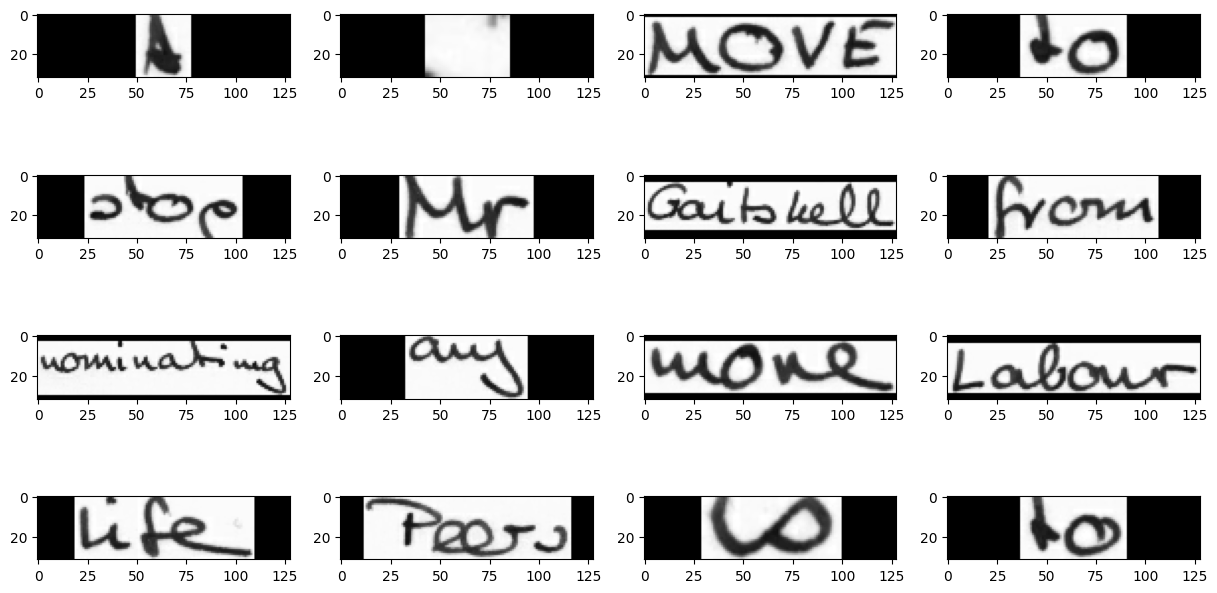

In [51]:
# Visualize test images 

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for data in inf_images.take(1):
  images = data["image"]
  # imm = images.reshape(images.shape[0], (images.shape[1]*images.shape[2]))
  # imm = imm.transpose()
  # print(imm.shape)
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  # ss = plt.imshow(imm, cmap="gray")
  # plt.show()
  for i in range(16): 
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    

  plt.show()

2023-12-09 07:47:12.402954: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


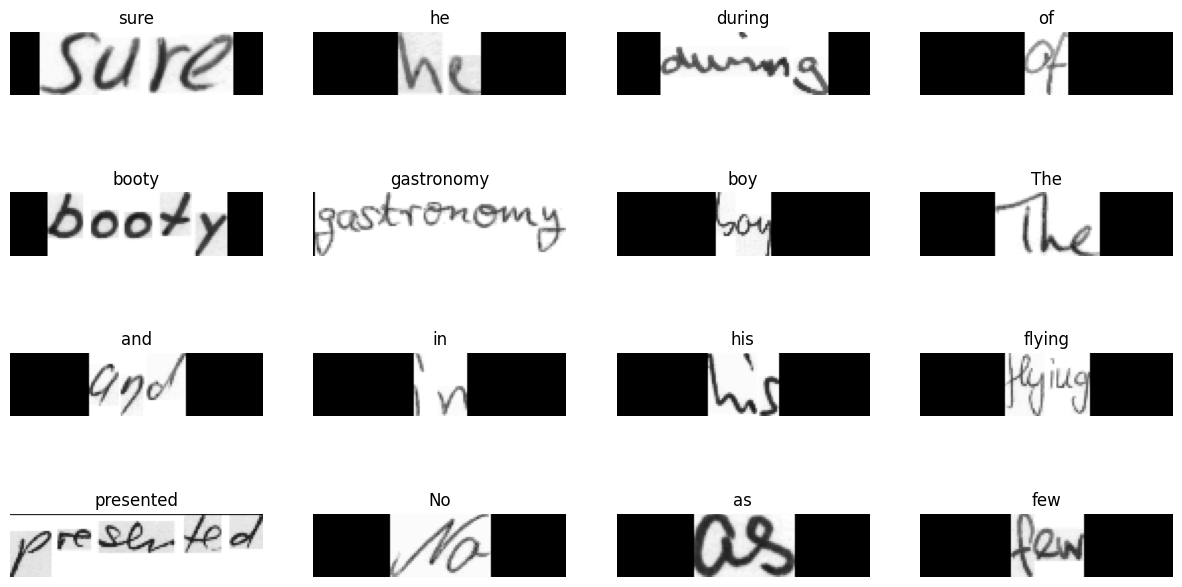

In [52]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16): 
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_chars(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()

In [53]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions.
    return y_pred

def build_model():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # first conv block
  x = keras.layers.Conv2D(
      32, (3,3), activation = "relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1"
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  # Second conv block
  x = keras.layers.Conv2D(
      64, (3,3), activation = "relu", kernel_initializer="he_normal",
      padding="same",
      name="Conv2"
  )(x)
  x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

  # We have two maxpool layers with pool size and strides 2
  # Hence downsampled feature maps are 4x smaller the number of filters in the last layer is 64, 
  # Reshape accordingly before passing the output to the RNN part of the model.
  
  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNN
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
  )(x)
  x = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)
  # +2 is to account for the two special tokens introduced by the CTC loss.
  # The recommendation comes here: https://git.10/J0eXP.
  x = keras.layers.Dense(
    len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)
  # Add CTC layer for calculating CTC Loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model.
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
  )
  
  # optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt)
  return model

# Get the model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

In [54]:
# Edit Distance is the most widely used metric for evaluating OCR models. In this section, we will implement it and use it as a callback to monitor
# ‘our model.

# We first segregate the validation images and their labels for convenience.

validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

In [55]:
def calculate_edit_distance(labels, predictions):
  # Get a single batch and convert its labels to sparse tensors.
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(
    predictions, input_length=input_len, greedy=True
  )[0][0][:, :max_len]
  sparse_predictions = tf.cast(
    tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
  )

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model
  def on_epoch_end(self, epoch, logs = None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
    print(f"Mean eidt distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")

In [57]:
# Now we are ready to kick off model training,

epochs = 50 # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
  model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[edit_distance_callback],
)

Epoch 1/50
1/1 [==============================] - 2s 2s/step
Mean eidt distance for each 1:  20.4195
1357/1357 [==============================] - 187s 133ms/step - loss: 13.5317 - val_loss: 11.6022
Epoch 2/50
1/1 [==============================] - 0s 23ms/step
Mean eidt distance for each 2:  20.0692
1357/1357 [==============================] - 93s 69ms/step - loss: 10.3462 - val_loss: 9.2906
Epoch 3/50
1/1 [==============================] - 0s 28ms/step
Mean eidt distance for each 3:  19.6766
1357/1357 [==============================] - 93s 68ms/step - loss: 8.5526 - val_loss: 7.2317
Epoch 4/50
1/1 [==============================] - 0s 27ms/step
Mean eidt distance for each 4:  18.8635
1357/1357 [==============================] - 95s 70ms/step - loss: 6.7379 - val_loss: 5.3968
Epoch 5/50
1/1 [==============================] - 0s 25ms/step
Mean eidt distance for each 5:  18.3384
1357/1357 [==============================] - 93s 69ms/step - loss: 5.4714 - val_loss: 4.4324
Epoch 6/50
1/1 [=

In [58]:
# Saving the model

# model.save_weights('/content/drive/MyDrive/Colab Notebooks/OCR_course/ocr_model_v4.h5')
# prediction_model.save_weights('/content/drive/MyDrive/Colab Notebooks/OCR_course/ocr_model_v5.h5')

# Below is working saved models
model.save("ocr_model.h5")
# prediction_model.save("/content/drive/MyDrive/Colab Notebooks/OCR_course/ocr_model_50_epoch.h5")

(64, 128, 32, 1)
2/2 [==============================] - 0s 24ms/step


2023-12-09 10:22:17.640425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


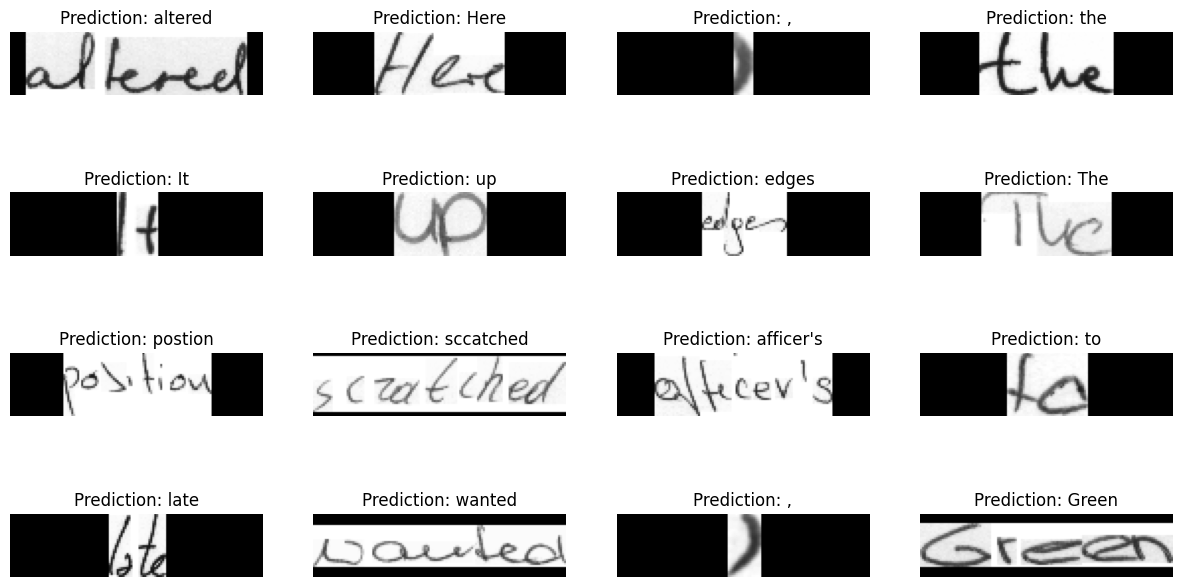

In [59]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [60]:
custom_objects = {"CTCLayer": CTCLayer}

In [61]:
reconstructed_model = keras.models.load_model("ocr_model.h5", custom_objects=custom_objects)

In [62]:
prediction_model = keras.models.Model(
  reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

(59, 128, 32, 1)
2/2 [==============================] - 2s 286ms/step


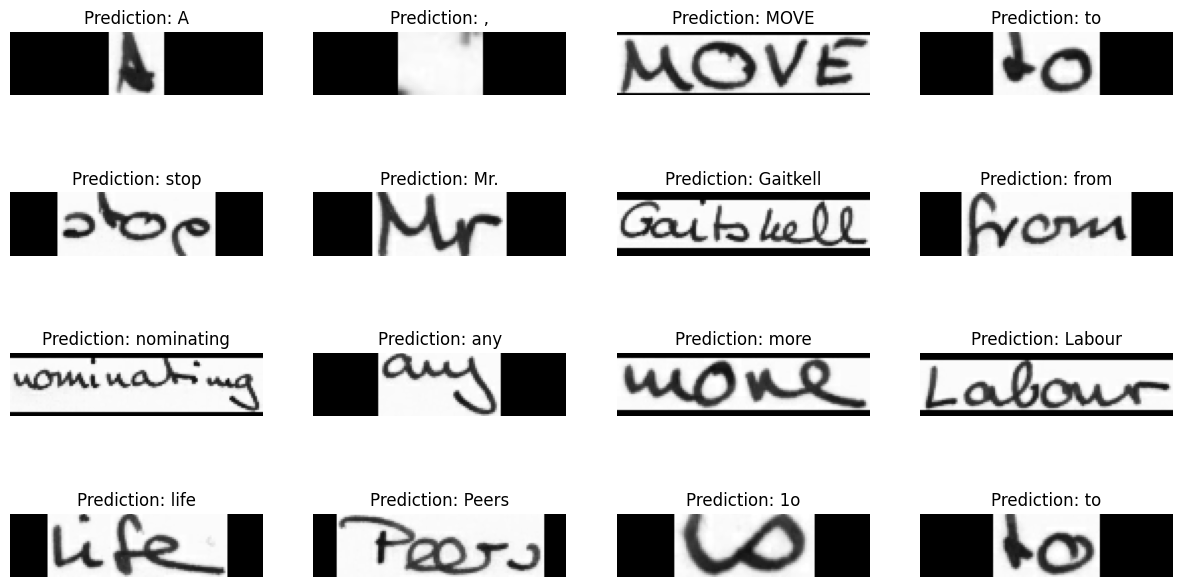

In [63]:
# Inference on New set of images
pred_test_text = []

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in inf_images.take(3):
    batch_images = batch["image"]
    # batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)
    # print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [64]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

['A', ',', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitkell', 'from', 'nominating', 'any', 'more', 'Labour', 'life', 'Peers', '1o', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour', 'A', '7', 'a', 'tomorrow', '"', 'Mr', '"', 'Michael', 'Foot', 'has', 'put', 'down', 'a', 'resolution', 'on', 'the', 'subject', 'ond', 'he', 'so', 'to', 'be', 'backed', 'by', 'Mr.', 'ur', '.', 'ill', 'bviffi', 'Ms', ',', 'A', 'F', 'for', 'Manchester', 'Exchange']


In [65]:
sentence = ' '.join(flat_list)
print(sentence)

A , MOVE to stop Mr. Gaitkell from nominating any more Labour life Peers 1o to be made at a meeting of Labour A 7 a tomorrow " Mr " Michael Foot has put down a resolution on the subject ond he so to be backed by Mr. ur . ill bviffi Ms , A F for Manchester Exchange
